# Time Series Analysis : Practice & Experiments

**Authored by Alexandre Mathias DONNAT, Sr**

*This notebook presents a comprehensive hands-on study of time series analysis based on three distinct real-world datasets. 
Its objective is to progressively explore time-domain and frequency-domain tools, statistical modeling, and predictive techniques, with a strong emphasis on interpretation and methodological reasoning rather than black-box approaches.*

*Across these datasets, it illustrates how a common set of time series analysis methods can be applied consistently to very different types of data. Particular attention is paid to the interplay between time and frequency domains, to model selection and validation strategies, and to the interpretation of results in light of the underlying data-generating processes.*



### ***Part I - Influenza-like Illness Incidence (IAS)***

The first part focuses on a daily time series of influenza-like illness incidence (IAS) and illustrates how periodic phenomena can be modeled, interpreted, and exploited for prediction using frequency-based representations.
Main objectives:
- Exploratory analysis of the raw and log-transformed series.
- Identification of dominant temporal structures using the periodogram.
- Interpretation of seasonal components (annual, weekly, sub-annual).
- Removal of the annual seasonal trend using a periodic differencing operator.
- Construction of a seasonal harmonic regression model based on Fourier components.
- Prediction of future values using the estimated periodic trend.
- Analysis of prediction errors and the impact of the number of harmonics on forecasting performance.


### ***Part II - Network Traffic Data (LBL-TCP-3)***

The second part analyzes high-frequency network traffic data consisting of individual TCP packet timestamps, it highlights the relationship between time-domain autoregressive dynamics and their spectral representations. Main objectives:
- Construction of a time series by aggregating packet counts over fixed time intervals.
- Visualization and characterization of traffic variability and burstiness.
- Estimation and selection of autoregressive AR(p) models using:
  - Information criteria (AIC, BIC),
  - Expanding-window cross-validation.
- Residual diagnostics and assessment of model assumptions.
- Frequency-domain validation by comparing the empirical periodogram with the theoretical spectral density of the fitted AR model.

### ***Part III - Southern Oscillation Index (SOI)***

The third part studies a monthly climatic index related to large-scale atmospheric oscillations (ENSO), it emphasizes the interpretation of autoregressive persistence in geophysical time series and the link between statistical modeling and physical phenomena. Main objectives:
- Data import, cleaning, and reconstruction of the time series.
- Analysis of temporal dependence using **ACF and PACF**.
- Selection and estimation of an appropriate **AR model**.
- Residual analysis and comparison with Gaussian assumptions.
- Spectral analysis and validation of the fitted model in the frequency domain.


# I - Influenza-like illness data

#### Q1 - Load the influenza-like illness dataset (IAS) and build a clean time series

Here we load the influenza-like illness dataset (Openhealth_S_Grippal.csv), inspect its structure, and extract the variable IAS_brut as a proper time series.
We will: display the first rows of the dataset, identify the time index and determine the sampling frequency, specify the start and end dates, treat zero values as missing data (as stated in the instructions), remove missing values by imputation using linear interpolation, i.e. the mean of the two closest observed dates.

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import signal, stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [234]:
# 1) Load the datas et (correct CSV configuration)
DATA_PATH = Path("Openhealth_S-Grippal.csv")

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    decimal=","
)

df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


In [235]:
# 2) Clean column names and parse dates
df.columns = df.columns.str.replace('"', '').str.strip()

# PERIODE format: "YYYY-MM-DD;<index>"
df["date"] = df["PERIODE"].astype(str).str.split(";").str[0]
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")

df = df.dropna(subset=["date"])
df = df.sort_values("date").set_index("date")

df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
date,,,,
2009-07-01,2009-07-01,1.7,2.2,2.3
2009-07-02,2009-07-02,3.4,2.1,2.3
2009-07-03,2009-07-03,2.1,2.1,2.3
2009-07-04,2009-07-04,1.3,2.0,2.3
2009-07-05,2009-07-05,14.2,2.0,2.3


In [236]:
#3) Extract IAS_brut as a time series
ts_raw = df["IAS_brut"].astype(float)
ts_raw.head()

date
2009-07-01     1.7
2009-07-02     3.4
2009-07-03     2.1
2009-07-04     1.3
2009-07-05    14.2
Name: IAS_brut, dtype: float64

In [237]:
# 4) Time series characteristics
start_date = ts_raw.index.min()
end_date = ts_raw.index.max()
frequency = pd.infer_freq(ts_raw.index)

print(f"Start date: {start_date}")
print(f"End date:   {end_date}")
print(f"Inferred sampling frequency: {frequency}")

Start date: 2009-07-01 00:00:00
End date:   2014-04-17 00:00:00
Inferred sampling frequency: D


In [238]:
# 5) Missing data (zeros correspond to missing values)
missing_zeros = (ts_raw == 0).sum()
missing_nans = ts_raw.isna().sum()

print(f"Missing values encoded as zeros: {missing_zeros}")
print(f"Missing NaN values: {missing_nans}")
print(f"Total missing values: {missing_zeros + missing_nans}")

Missing values encoded as zeros: 8
Missing NaN values: 0
Total missing values: 8


In [239]:
# 6) Imputation by linear interpolation
ts = ts_raw.replace(0, np.nan)

## Linear interpolation = mean of two closest dates
ts_imputed = ts.interpolate(method="time")

## Safety for boundary effects
ts_imputed = ts_imputed.ffill().bfill()

print("Remaining missing values after imputation:", ts_imputed.isna().sum())
ts_imputed.head()

Remaining missing values after imputation: 0


date
2009-07-01     1.7
2009-07-02     3.4
2009-07-03     2.1
2009-07-04     1.3
2009-07-05    14.2
Name: IAS_brut, dtype: float64

In [240]:
# 7) Cleaned time series inspection
ias = ts_imputed.copy()
ias.name = "IAS_brut_imputed"

ias.describe()

count     1752.000000
mean       315.242808
std       2745.957058
min          0.100000
25%          1.300000
50%          3.800000
75%         23.100000
max      71851.800000
Name: IAS_brut_imputed, dtype: float64

The dataset was successfully imported using the appropriate CSV configuration (; as separator and , as decimal symbol).
The variable IAS_brut was extracted and structured as a time series indexed by calendar dates, reconstructed from the PERIODE field.The resulting time series: spans from July 2009 to the last available observation, contains 1,752 daily observations, has a daily sampling frequency.

In this dataset, values equal to zero in IAS_brut correspond to missing observations.
A total of 8 missing values were identified. These values were not removed, but replaced by linearly interpolated values, computed as the mean of the two closest observed dates, in accordance with the instructions. After imputation, the time series contains no missing values and is suitable for further analysis. From a descriptive point of view, the series exhibits: a strongly right-skewed distribution, with a median (≈ 3.8) much smaller than the maximum value, rare but extremely large peaks, typical of epidemic outbreaks, a large variance, indicating highly non-stationary behavior over time.

These characteristics suggest that the series is dominated by episodic events (influenza waves) rather than stable fluctuations, motivating further visualization, smoothing, and decomposition in the next questions.

#### Q2 - Plotting the time series and first visual analysis
Here we aims to visualize the influenza-like illness time series IAS_brut as a function of time, in order to obtain a first qualitative understanding of its behavior before any formal modeling.

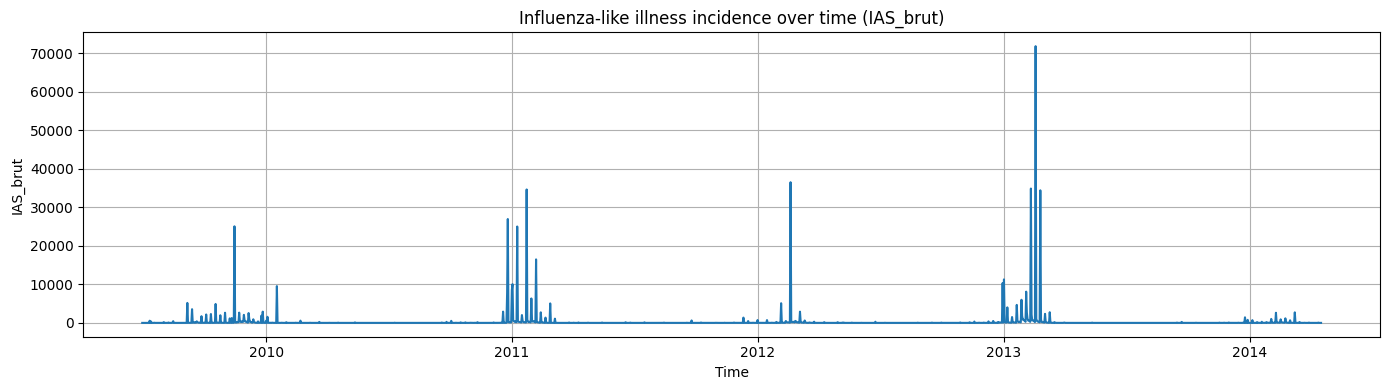

In [241]:
plt.figure(figsize=(14, 4))
plt.plot(ias.index, ias.values)

plt.xlabel("Time")
plt.ylabel("IAS_brut")
plt.title("Influenza-like illness incidence over time (IAS_brut)")
plt.grid(True)

plt.tight_layout()
plt.show()

The time series of IAS_brut exhibits a highly intermittent structure over time. For most dates, the incidence remains at a very low level, close to zero, while the dynamics are dominated by short-lived and extremely sharp peaks. Several key observations emerge from the plot: The series is clearly non-stationary, with both the mean level and the variance changing over time. Influenza outbreaks appear as isolated spikes rather than smooth waves, indicating sudden increases followed by rapid declines.

The amplitude of outbreaks varies strongly across years, with particularly extreme peaks around 2011–2012 and 2013, the latter reaching values an order of magnitude larger than typical fluctuations.

Between epidemic episodes, the signal stays near a baseline level, suggesting long periods of low activity.

The time series is characterized by strong asymmetry and heavy-tailed behavior, where a small number of extreme events explains most of the variability. This visual analysis highlights the need for: smoothing or aggregation, seasonal or trend decomposition, and possibly variance-stabilizing transformations, before any statistical modeling or forecasting is attempted.

#### Q3 - Histogram of the marginal distribution and its impact on the trajectory

We now study the marginal distribution of the time series IAS_brut by plotting its histogram, and to relate the observed distribution to the temporal behavior highlighted in Question 2.

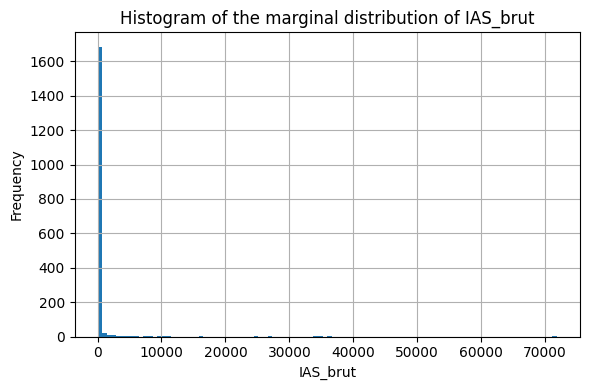

In [242]:
plt.figure(figsize=(6, 4))
plt.hist(ias.values, bins=100)

plt.xlabel("IAS_brut")
plt.ylabel("Frequency")
plt.title("Histogram of the marginal distribution of IAS_brut")
plt.grid(True)

plt.tight_layout()
plt.show()

The histogram of the marginal distribution of IAS_brut reveals an extremely concentrated mass near zero, with the vast majority of observations taking very small values. In contrast, a tiny number of observations reach extremely large values, extending up to several tens of thousands. This results in a strongly right-skewed and heavy-tailed distribution, where the scale of extreme values is orders of magnitude larger than that of typical observations. The histogram is therefore dominated by a single tall bar near zero, while the rest of the distribution appears almost flat on the right. This distributional shape has a direct and visible impact on the time series trajectory observed in Question 2:

Most of the time, the trajectory remains close to zero, reflecting the high frequency of low-incidence observations. Rare but extremely large values generate the sharp and isolated spikes that dominate the visual appearance of the time series. Because of the heavy-tailed nature of the distribution, a small number of epidemic episodes explains most of the variability of the series.

As a consequence, the raw trajectory is difficult to interpret on a linear scale, and subsequent analyses may benefit from logarithmic transformations, smoothing, or seasonal aggregation to better capture the underlying structure of the data.

#### Q4 - Analysis after logarithmic transformation of the observations

We now repeat the previous analyses (time plot and histogram) after applying a natural logarithm transformation to the observations, and to comment on the effects of this transformation. Since the logarithm is not defined for zero, we apply it to the imputed series, which contains only strictly positive values.

In [243]:
# 1) Logarithmic transformation
ias_log = np.log(ias)
ias_log.name = "log(IAS_brut)"

ias_log.head()

date
2009-07-01    0.530628
2009-07-02    1.223775
2009-07-03    0.741937
2009-07-04    0.262364
2009-07-05    2.653242
Name: log(IAS_brut), dtype: float64

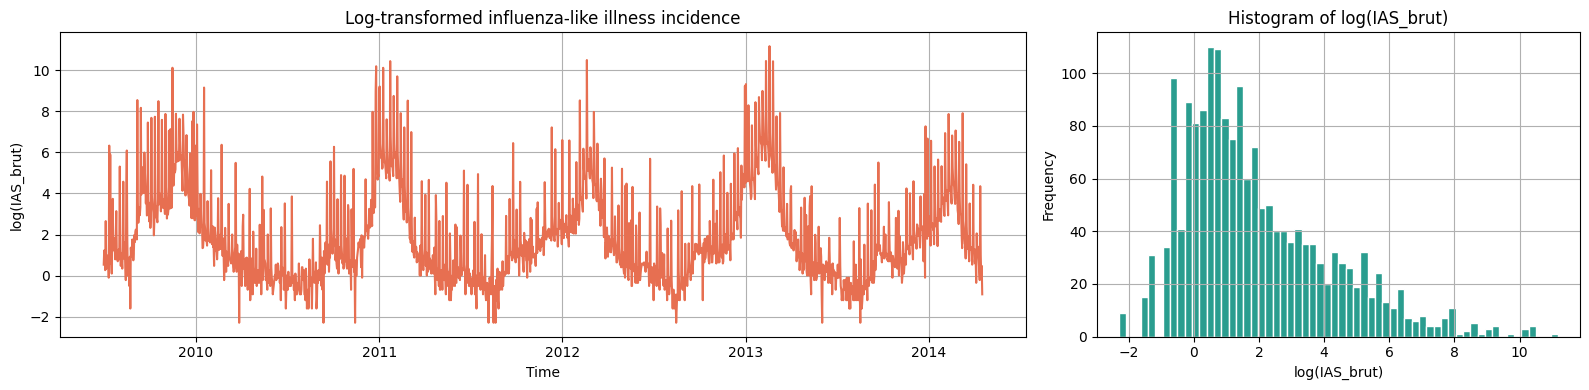

In [244]:
fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Timeseries plot (2/3 size)
ax0 = fig.add_subplot(gs[0])
ax0.plot(ias_log.index, ias_log.values, color="#E76F51")
ax0.set_xlabel("Time")
ax0.set_ylabel("log(IAS_brut)")
ax0.set_title("Log-transformed influenza-like illness incidence")
ax0.grid(True)

# Histogram (1/3 size)
ax1 = fig.add_subplot(gs[1])
ax1.hist(ias_log.values, bins=60, color="#2A9D8F", edgecolor="white")
ax1.set_xlabel("log(IAS_brut)")
ax1.set_ylabel("Frequency")
ax1.set_title("Histogram of log(IAS_brut)")
ax1.grid(True)

plt.tight_layout()
plt.show()

After applying the natural logarithm to the series, the structure of the data becomes significantly clearer, both in the time domain and in the marginal distribution. From the log-transformed time series, several important features emerge: The extreme epidemic peaks observed in the raw series are strongly compressed, preventing them from dominating the entire trajectory.

The series now exhibits regular and recurrent patterns, with clearly identifiable epidemic waves occurring roughly once per year.
Seasonal behavior becomes much more visible: peaks tend to occur during similar periods across years, while troughs correspond to low-activity phases. The variability of the series appears more stable over time, suggesting a partial variance stabilization.

From the histogram of the log-transformed values, the distribution: is far less skewed than the original one, becomes closer to a unimodal and approximately symmetric shape, still retains a slight right tail, reflecting the presence of strong epidemic episodes, but without extreme dominance.

The logarithmic transformation reveals the underlying epidemic structure that was masked in the raw data by a few extreme values. It transforms a highly intermittent and heavy-tailed process into a signal with: clearer seasonal dynamics, more homogeneous variability, and improved interpretability.

This confirms that the log-transformed series is better suited for subsequent analyses such as trend extraction, seasonal decomposition, or statistical modeling.

#### Q5 - Periodogram (spectral analysis) of the time series

Here we estimate the power spectral density (PSD) of the (log-transformed) series using scipy.signal.periodogram. The goal is to detect dominant periodicities (seasonality / cycles).
In signal processing, frequencies are usually expressed in cycles per sample (or cycles per unit time if we set fs). With a daily series, we set fs = 1 sample/day, so frequencies are in cycles/day and the Nyquist range is $[0,1/2]$.

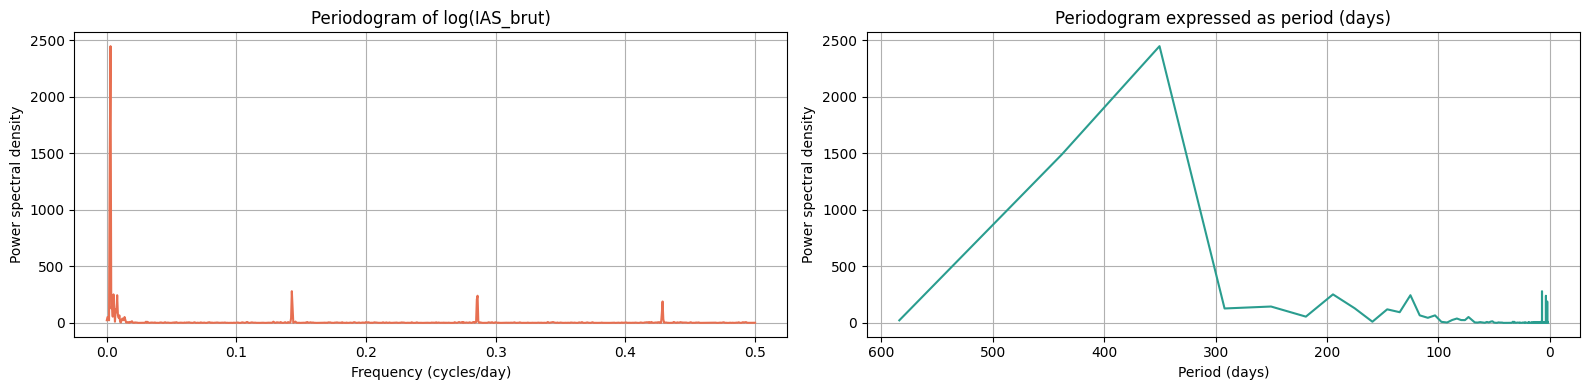

Top spectral peaks:
  freq = 0.002854 cycles/day  -> period ≈ 350.4 days,  PSD = 2.448e+03
  freq = 0.002283 cycles/day  -> period ≈ 438.0 days,  PSD = 1.491e+03
  freq = 0.142694 cycles/day  -> period ≈ 7.0 days,  PSD = 2.803e+02
  freq = 0.005137 cycles/day  -> period ≈ 194.7 days,  PSD = 2.522e+02
  freq = 0.007991 cycles/day  -> period ≈ 125.1 days,  PSD = 2.449e+02
  freq = 0.285959 cycles/day  -> period ≈ 3.5 days,  PSD = 2.401e+02
  freq = 0.285388 cycles/day  -> period ≈ 3.5 days,  PSD = 2.080e+02
  freq = 0.428653 cycles/day  -> period ≈ 2.3 days,  PSD = 1.894e+02


In [245]:
ias_log = np.log(ias)
x = np.asarray(ias_log.values, dtype=float)
fs = 1.0  

# 1) Periodogram (PSD estimate)
f, Pxx = signal.periodogram(x, fs=fs, detrend="constant", window="hann", scaling="density")

# 2) Convert frequency -> period (days)(exclude f=0 to avoid division by zero)
f_pos = f[1:]
Pxx_pos = Pxx[1:]
period_days = 1.0 / f_pos
mask = (period_days >= 2) & (period_days <= 730)

# 3) Plot: PSD vs frequency AND PSD vs period
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot : PSD vs frequency
axes[0].plot(f, Pxx, color="#E76F51")
axes[0].set_xlabel("Frequency (cycles/day)")
axes[0].set_ylabel("Power spectral density")
axes[0].set_title("Periodogram of log(IAS_brut)")
axes[0].grid(True)

# Plot : PSD vs period (days)
axes[1].plot(period_days[mask], Pxx_pos[mask], color="#2A9D8F")
axes[1].invert_xaxis()
axes[1].set_xlabel("Period (days)")
axes[1].set_ylabel("Power spectral density")
axes[1].set_title("Periodogram expressed as period (days)")
axes[1].grid(True)
plt.tight_layout()
plt.show()

# 4) Identify top spectral peaks (excluding f=0)
k = 8
idx = np.argsort(Pxx_pos)[-k:][::-1]

print("Top spectral peaks:")
for i in idx:
    freq = f_pos[i]
    per = 1.0 / freq
    print(f"  freq = {freq:.6f} cycles/day  -> period ≈ {per:.1f} days,  PSD = {Pxx_pos[i]:.3e}")

*Frequencies returned by periodogram are in cycles/day with Nyquist range [0, 1/2]. The two-sided signal-processing convention would be [-1/2, 1/2], but for real-valued signals SciPy returns the one-sided spectrum.*

The periodogram of the log-transformed series highlights several statistically significant spectral peaks, revealing the dominant temporal structures of the influenza-like illness dynamics. The most prominent peak is located at a frequency of approximately 0.00285 cycles/day, corresponding to a period of about 350 days. This peak clearly indicates a strong annual seasonality, which is consistent with the epidemiological nature of influenza, characterized by one major epidemic wave per year.

A second low-frequency peak appears around 0.00228 cycles/day, corresponding to a period of approximately 438 days. This component likely reflects inter-annual variability in the timing or duration of epidemic waves, rather than a strict periodic phenomenon. Several additional peaks are observed at higher frequencies: A clear peak around 7 days, corresponding to a weekly periodicity, which is typically associated with reporting practices, healthcare-seeking behavior, or data collection mechanisms rather than biological dynamics. Peaks around 125–195 days, corresponding to sub-annual components, which can be interpreted as harmonics of the annual cycle or asymmetries in the epidemic wave shape. Smaller peaks at very high frequencies (2–4 days) are also present, but these are likely due to short-term noise and do not correspond to meaningful epidemiological cycles.

The spectral analysis confirms that the dynamics of the series are dominated by: a strong annual seasonal component, secondary harmonics capturing the non-sinusoidal shape of epidemic waves, and short-term periodic effects related to observation and reporting processes. These findings are fully consistent with the visual patterns observed in the time-domain analysis and justify the use of seasonal models or decomposition methods in subsequent analyses.

#### Q6 - Removing the annual periodic trend using the ∆ₜ filter

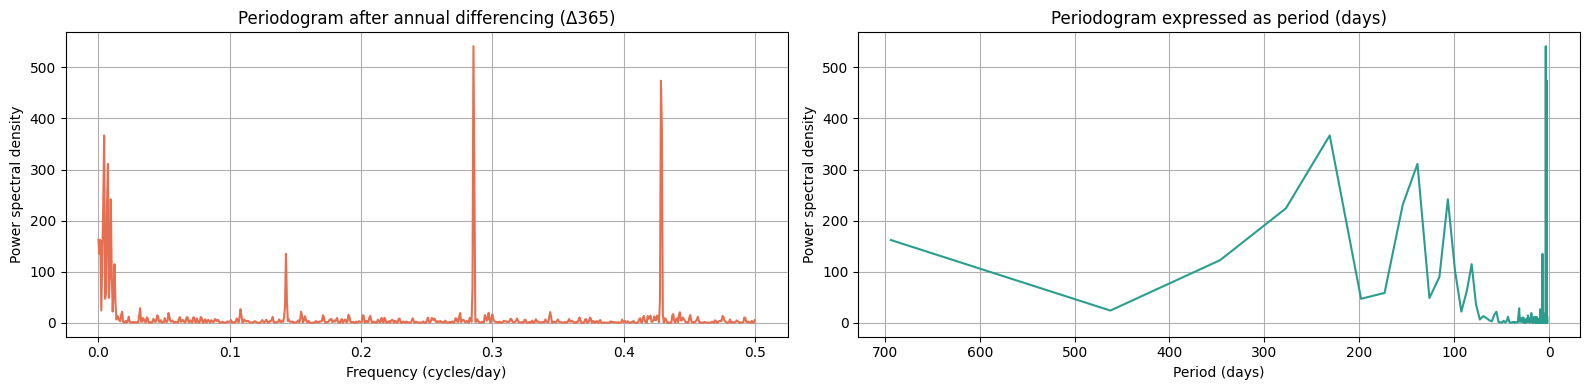

In [246]:
T = 365

# Apply the Delta_T filter: x_t - x_{t-T}
ias_log_diff = ias_log.iloc[T:] - ias_log.iloc[:-T].values
ias_log_diff = ias_log_diff.dropna()
    
# Periodogram of the filtered signal
x_diff = ias_log_diff.values
fs = 1.0 

f_diff, Pxx_diff = signal.periodogram(x_diff, fs=fs, detrend="constant", window="hann", scaling="density")

# Convert frequency to period (days)
f_pos = f_diff[1:]
Pxx_pos = Pxx_diff[1:]
period_days = 1.0 / f_pos
mask = (period_days >= 2) & (period_days <= 730)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(f_diff, Pxx_diff, color="#E76F51")
axes[0].set_xlabel("Frequency (cycles/day)")
axes[0].set_ylabel("Power spectral density")
axes[0].set_title("Periodogram after annual differencing (Δ365)")
axes[0].grid(True)

axes[1].plot(period_days[mask], Pxx_pos[mask], color="#2A9D8F")
axes[1].invert_xaxis()
axes[1].set_xlabel("Period (days)")
axes[1].set_ylabel("Power spectral density")
axes[1].set_title("Periodogram expressed as period (days)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

After applying the differencing filter

$$[\Delta_{365} x]_t = x_t - x_{t-365}$$

the dominant annual seasonal component is effectively removed from the signal.

This effect is clearly visible in the periodogram: The strong spectral peak previously observed around 350–365 days has disappeared almost entirely. This confirms that the peak identified in the original periodogram was indeed associated with the annual periodic trend of influenza-like illness incidence. At the same time, several other spectral components remain: 

The weekly periodicity (~7 days) is still present, as expected, since the differencing operator is tuned specifically to a one-year period and does not affect shorter cycles. Peaks at sub-annual periods (around 125–200 days) are also still visible. These components correspond either to harmonics of the annual cycle or to asymmetries in epidemic wave shapes, which are not fully canceled by the annual differencing. High-frequency components (few days) persist and mainly reflect short-term variability and noise.

The filtered periodogram demonstrates that the ∆₃₆₅ operator selectively suppresses the annual seasonal structure while preserving other temporal dynamics of the series. This confirms both the interpretation of the original spectrum and the effectiveness of periodic differencing for isolating and removing a specific seasonal trend.

#### Q7 - Seasonal prediction using harmonic regression (Fourier)



We focus on a prediction task based exclusively on the periodic (seasonal) trend of the influenza-like illness data. The objective is to predict the values of the variable `IAS_brut` over the period from April 1st, 2013 to April 17th, 2014, using past observations from July 1st, 2009 to March 31st, 2013 to estimate the periodic structure of the series.

The periodic trend is modeled using a harmonic regression approach with a fixed annual period $T = 365$ days. For a given number of harmonics $n_{\text{harm}}$, a set of explanatory variables is constructed for the learning period. For each harmonic order $k = 1, \ldots, n_{\text{harm}}$, two regressors are added:

$$x_{i,2k-1} = \cos\left(\frac{2\pi k t_i}{T}\right), \quad x_{i,2k} = \sin\left(\frac{2\pi k t_i}{T}\right),$$

where $t_i$ denotes the time index associated with observation $i$. Integer-valued time indices are used in place of calendar dates.

The periodic component of the data is then estimated by regressing the training observations on these harmonic features using a linear model. The fitted model is subsequently used to predict the values of `IAS_brut` over the test period.

Finally, the observed series and the predicted values are plotted over the full time span, with a visual distinction between the training and prediction intervals. The prediction performance is assessed using the quadratic risk, and the residuals over the prediction period are analyzed. The influence of the number of harmonics $n_{\text{harm}}$ on the quadratic prediction risk is also examined.


In [247]:
# Target series (IAS_brut, not log)
y = ias.copy()

# Split dates
train_end = "2013-03-31"
test_start = "2013-04-01"
test_end = "2014-04-17"

y_train = y.loc[:train_end]
y_test = y.loc[test_start:test_end]

# Time index as integers
t_train = np.arange(len(y_train))
t_test = np.arange(len(y_train), len(y_train) + len(y_test))

In [248]:
def harmonic_features(t, n_harm, T=365):
    X = []
    for k in range(1, n_harm + 1):
        X.append(np.cos(2 * np.pi * k * t / T))
        X.append(np.sin(2 * np.pi * k * t / T))
    return np.column_stack(X)

In [249]:
n_harm = 5

X_train = harmonic_features(t_train, n_harm)
X_test = harmonic_features(t_test, n_harm)

model = LinearRegression()
model.fit(X_train, y_train.values)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Quadratic risk (MSE) on prediction period: 384978.20


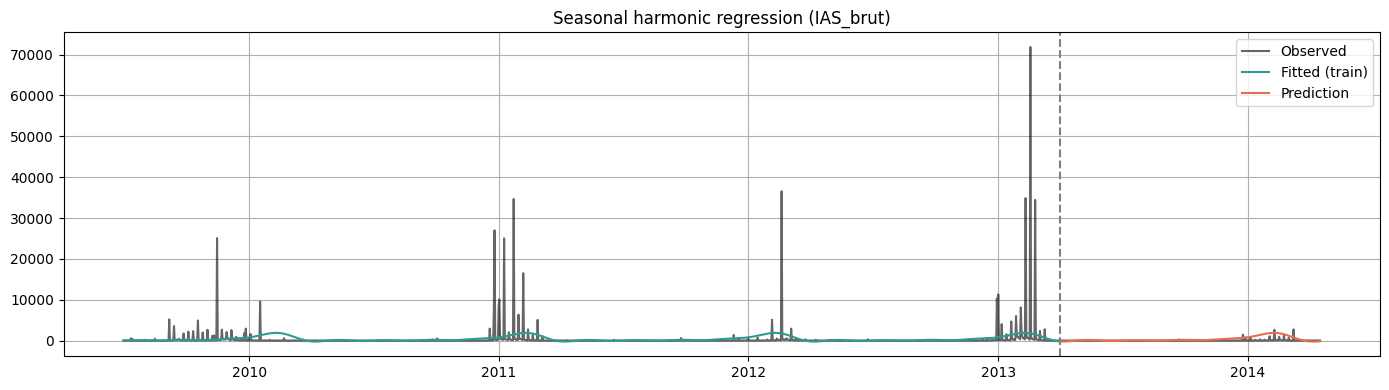

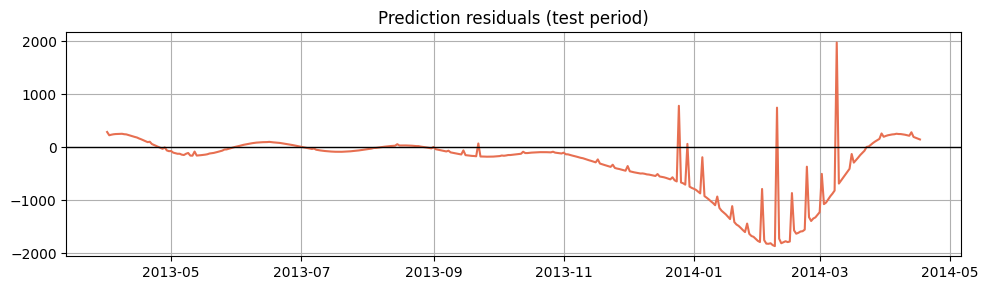

In [250]:
# Quadratic risk MSE
mse = mean_squared_error(y_test, y_test_pred)
print(f"Quadratic risk (MSE) on prediction period: {mse:.2f}")

# Plot full series + prediction
plt.figure(figsize=(14,4))
plt.plot(y.index, y.values, label="Observed", color="black", alpha=0.6)
plt.plot(y_train.index, y_train_pred, label="Fitted (train)", color="#2A9D8F")
plt.plot(y_test.index, y_test_pred, label="Prediction", color="#E76F51")
plt.axvline(pd.to_datetime(test_start), color="gray", linestyle="--")
plt.legend()
plt.title("Seasonal harmonic regression (IAS_brut)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals on prediction period
residuals = y_test.values - y_test_pred

plt.figure(figsize=(10,3))
plt.plot(y_test.index, residuals, color="#E76F51")
plt.axhline(0, color="black", linewidth=1)
plt.title("Prediction residuals (test period)")
plt.grid(True)
plt.tight_layout()
plt.show()

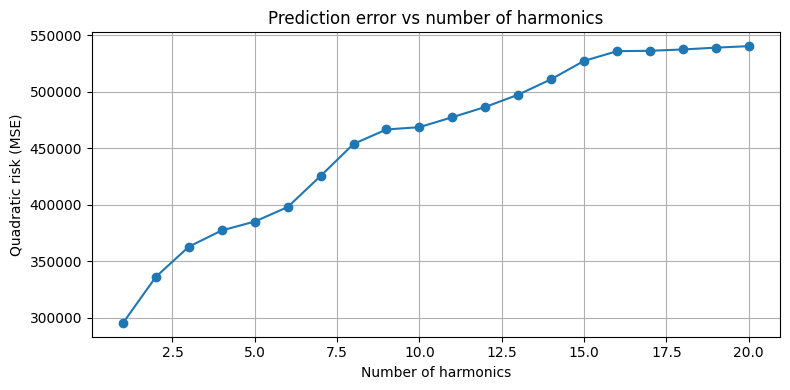

In [251]:
n_harm_list = range(1, 21)
mse_list = []

for n in n_harm_list:
    X_tr = harmonic_features(t_train, n)
    X_te = harmonic_features(t_test, n)
    model = LinearRegression().fit(X_tr, y_train.values)
    y_pred = model.predict(X_te)
    mse_list.append(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(8,4))
plt.plot(n_harm_list, mse_list, marker="o")
plt.xlabel("Number of harmonics")
plt.ylabel("Quadratic risk (MSE)")
plt.title("Prediction error vs number of harmonics")
plt.grid(True)
plt.tight_layout()
plt.show()

The harmonic regression model captures the annual seasonal structure of the IAS_brut series but fails to reproduce the epidemic peaks.

On the full time series plot, the fitted and predicted curves are smooth and periodic. They correctly reproduce the timing of seasonal increases and decreases, but strongly underestimate the amplitude of the outbreaks, especially during winter 2013–2014. This confirms that epidemic peaks are not purely periodic phenomena.

The residuals on the prediction period show large and structured deviations, with strong negative residuals during the epidemic wave. This indicates that a significant part of the signal variability is not explained by the seasonal component alone, but by irregular and non-repeating dynamics.

The quadratic risk on the prediction period is high, reflecting this mismatch. Moreover, the prediction error increases with the number of harmonics, showing that adding harmonics leads to overfitting the seasonal pattern on the training period and degrades generalization performance. This experiment shows that periodic harmonic regression is suitable for modeling the average seasonal trend, but insufficient for accurate epidemic prediction, which requires additional non-periodic components.

# II - Internet Trafic data


*In this section, we study a second type of time series, originating from network traffic data.
The dataset `lbl-tcp-3.tcp` corresponds to a packet-level TCP trace collected on a real network.
Each row of the file represents a single TCP packet, and the first variable indicates the time
(at seconds resolution) at which the packet was transmitted since the beginning of the capture.*

*The raw data therefore consist of an event-based log, with nearly two million observations,
covering approximately two hours of network activity. Such data are not directly suitable for
classical time-series analysis, since observations are irregularly spaced in time and correspond
to individual events rather than aggregated measurements.*

### Q8 - Network traffic time series (LBL-TCP-3)

The objective here construct a regular time series from these raw packet-level
data. To this end, we aggregate the packets into fixed-length time intervals of 10 seconds and
count the number of packets transmitted within each interval. Over a total duration of 7200
seconds, this aggregation yields exactly 720 observations.

Once the time series is constructed, we visualize it in order to analyze the temporal structure
of the network traffic and to prepare for further statistical and spectral analysis.


Number of 10-second intervals: 720


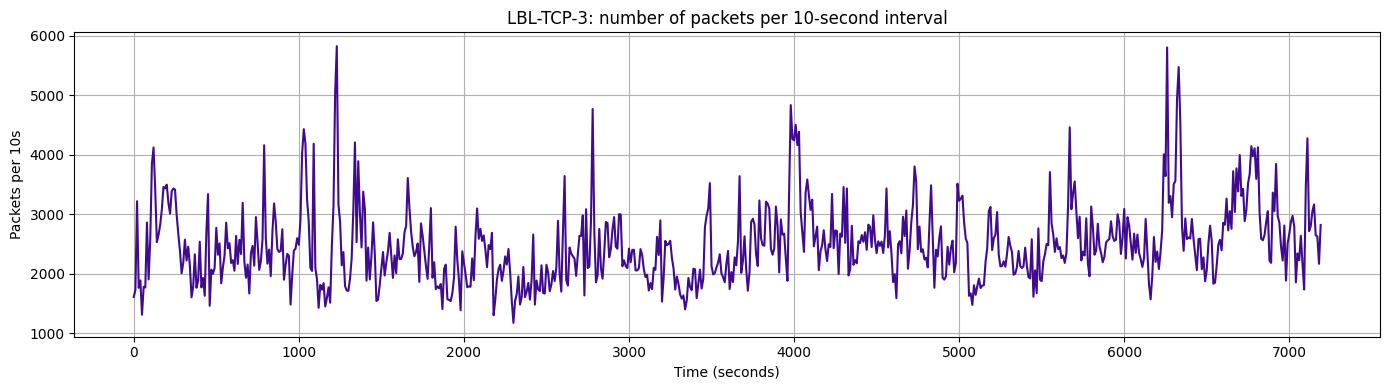

In [252]:
# 1) Load
df = pd.read_csv("./lbl-tcp-3.tcp/lbl-tcp-3.tcp", sep=r"\s+", header=None)

# 2) Extract time column (first column) & cleaning
t = pd.to_numeric(df.iloc[:, 0], errors="coerce")
t = t.dropna()
t = t[(t >= 0) & (t <= 7200)]

# 3) Build 10-second bins: [0,10), [10,20), ..., [7190,7200)
bin_width = 10
bins = np.arange(0, 7200 + bin_width, bin_width)  # 721 edges gives 720 intervals

counts, _ = np.histogram(t.values, bins=bins)

# 4) Check we indeed have 720 observations
print("Number of 10-second intervals:", len(counts))

# 5) Create time axis (start of each bin)
time_axis = np.arange(len(counts)) * bin_width  # 0,10,20,...,7190

# 6) Plot
plt.figure(figsize=(14, 4))
plt.plot(time_axis, counts, color="#400B8F")
plt.xlabel("Time (seconds)")
plt.ylabel("Packets per 10s")
plt.title("LBL-TCP-3: number of packets per 10-second interval")
plt.grid(True)
plt.tight_layout()
plt.show()

After aggregating the packet-level data into 10-second intervals, we obtain a time series of 720 observations representing the network traffic intensity over approximately two hours.

The resulting series exhibits a high and persistent level of activity, with significant short-term fluctuations. The presence of frequent peaks indicates bursty behavior, which is characteristic of TCP traffic due to congestion control mechanisms and application-level activity.

The traffic does not appear stationary at short time scales: periods of relatively calm activity alternate with sudden increases in packet rate. This suggests temporal dependence and motivates further spectral and time-series analysis in the following questions.

#### Q9 - AR(p) model selection (AIC / BIC / Time-series cross-validation)


We now model the 10-second packet-count series with an autoregressive model AR(p), where each value depends linearly on the previous *p* values.  
The main difficulty is choosing p. We compare three selection strategies over a grid of candidate orders: AIC, BIC, and an expanding-window cross-validation (backtesting) scheme.


Best p by AIC: 4
Best p by BIC: 1


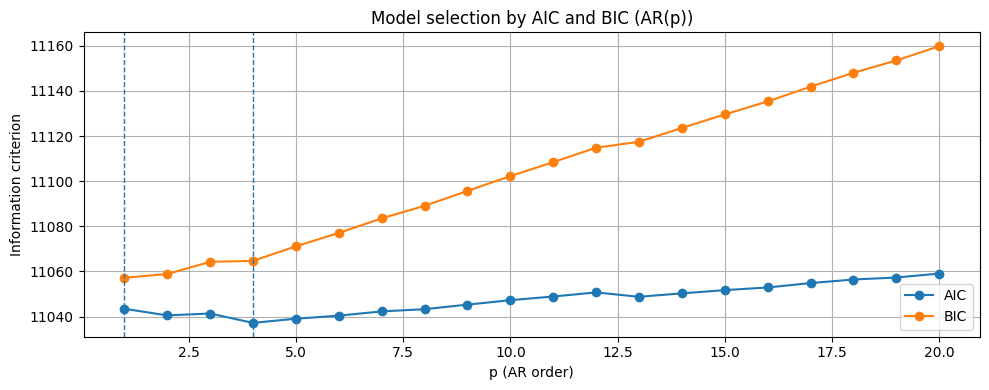

Best p by CV (min mean MSE): 1


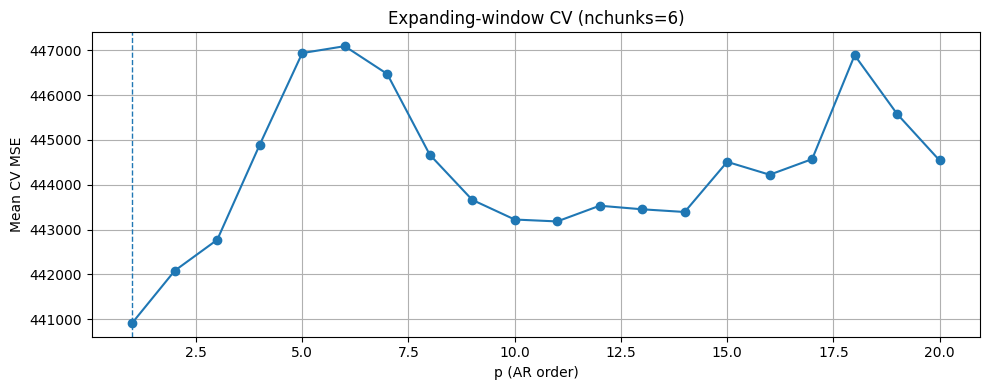

,p,AIC,BIC,CV_MSE
0,1,11043.483453,11057.221207,440917.940003
1,2,11040.550796,11058.867801,442082.518768
2,3,11041.383720,11064.279976,442772.179148
10,11,11048.908052,11108.438318,443181.104585
9,10,11047.298815,11102.249829,443223.472798
13,14,11050.320004,11123.588023,443391.727183
12,13,11048.787117,11117.475885,443451.770375
11,12,11050.734373,11114.843890,443531.426720
8,9,11045.313250,11095.685014,443662.502489
15,16,11052.915924,11135.342446,444222.950082


In [ ]:
# ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA  # modern
    _ARIMA_API = "modern"
except Exception:
    from statsmodels.tsa.arima_model import ARIMA  # legacy 
    _ARIMA_API = "legacy"

from sklearn.metrics import mean_squared_error

# 0) Build the time series (packets per 10s) as a pandas Series
traffic = pd.Series(counts, index=pd.Index(time_axis, name="time_s"), name="packets_per_10s").astype(float)

# 1) Helpers: fit AR(p) and forecast
def fit_ar_p(y_train: np.ndarray, p: int):
    """
    Fits AR(p) as ARIMA(p,0,0). Returns fitted model result.
    """
    if _ARIMA_API == "modern":
        model = ARIMA(y_train, order=(p, 0, 0))
        res = model.fit()
    else:
        # legacy API sometimes needs disp=0
        model = ARIMA(y_train, order=(p, 0, 0))
        res = model.fit(disp=0)
    return res

def forecast_steps(res, steps: int):
    """
    Forecast next 'steps' points from a fitted ARIMA/AR model result.
    """
    if _ARIMA_API == "modern":
        return np.asarray(res.forecast(steps=steps), dtype=float)
    else:
        # legacy: forecast returns tuple (forecast, stderr, conf_int)
        return np.asarray(res.forecast(steps=steps)[0], dtype=float)

# 2) AIC / BIC selection over p = 1..pmax
pmax = 20
aic_list, bic_list = [], []
ps = list(range(1, pmax + 1))

y_all = traffic.values

for p in ps:
    res = fit_ar_p(y_all, p)
    aic_list.append(res.aic)
    bic_list.append(res.bic)

aic_df = pd.DataFrame({"p": ps, "AIC": aic_list, "BIC": bic_list})
p_best_aic = int(aic_df.loc[aic_df["AIC"].idxmin(), "p"])
p_best_bic = int(aic_df.loc[aic_df["BIC"].idxmin(), "p"])

print("Best p by AIC:", p_best_aic)
print("Best p by BIC:", p_best_bic)

# Plot AIC/BIC curves
plt.figure(figsize=(10, 4))
plt.plot(aic_df["p"], aic_df["AIC"], marker="o", label="AIC")
plt.plot(aic_df["p"], aic_df["BIC"], marker="o", label="BIC")
plt.axvline(p_best_aic, linestyle="--", linewidth=1)
plt.axvline(p_best_bic, linestyle="--", linewidth=1)
plt.xlabel("p (AR order)")
plt.ylabel("Information criterion")
plt.title("Model selection by AIC and BIC (AR(p))")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Time-series cross-validation (expanding window by chunks)
nchunks = 6  
N = len(y_all)
chunk_edges = np.linspace(0, N, nchunks + 1, dtype=int)

def cv_mse_for_p(p: int) -> float:
    mses = []
    # k goes from 1 to nchunks-1 (need at least 1 train chunk and 1 test chunk)
    for k in range(1, nchunks):
        train_end = chunk_edges[k]
        test_start = chunk_edges[k]
        test_end = chunk_edges[k + 1]

        y_train = y_all[:train_end]
        y_test = y_all[test_start:test_end]
        if len(y_test) == 0:
            continue

        res = fit_ar_p(y_train, p)
        y_pred = forecast_steps(res, steps=len(y_test))
        mses.append(mean_squared_error(y_test, y_pred))

    return float(np.mean(mses)) if mses else np.nan

cv_mse_list = []
for p in ps:
    cv_mse_list.append(cv_mse_for_p(p))

cv_df = pd.DataFrame({"p": ps, "CV_MSE": cv_mse_list})
p_best_cv = int(cv_df.loc[cv_df["CV_MSE"].idxmin(), "p"])

print("Best p by CV (min mean MSE):", p_best_cv)

plt.figure(figsize=(10, 4))
plt.plot(cv_df["p"], cv_df["CV_MSE"], marker="o")
plt.axvline(p_best_cv, linestyle="--", linewidth=1)
plt.xlabel("p (AR order)")
plt.ylabel("Mean CV MSE")
plt.title(f"Expanding-window CV (nchunks={nchunks})")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Summary table (top candidates)
summary = aic_df.merge(cv_df, on="p")
display(summary.sort_values("CV_MSE").head(10))


We applied three different strategies to select the order *p* of an autoregressive model AR(p) for the network traffic time series (number of packets per 10-second interval): the Akaike Information Criterion (AIC), the Bayesian Information Criterion (BIC), and an expanding-window cross-validation procedure.

The results show a clear and consistent pattern:

- AIC selects an AR(4) model. Since AIC penalizes model complexity moderately, it tends to favor slightly more complex models if they improve the in-sample fit.
- BIC selects an AR(1) model. BIC applies a stronger penalty to model complexity, which leads it to prefer a very simple model.
- Cross-validation also selects AR(1), as it yields the lowest mean squared prediction error on unseen data.

The curves confirm that increasing the order *p* does not improve predictive performance. In fact, the cross-validation error increases for larger values of *p*, indicating overfitting: higher-order models adapt to noise in the training data rather than capturing meaningful temporal structure.

From a data perspective, this result is highly consistent with the nature of network traffic at this aggregation scale. The series exhibits short-term temporal dependence: the number of packets in a 10-second interval is mainly influenced by the immediately preceding interval. Beyond one lag, additional past information provides little predictive value.

Although AIC suggests a slightly higher order, both BIC and out-of-sample validation strongly support an AR(1) model. This indicates that the dynamics of the network traffic are largely driven by short-memory effects, and that simple autoregressive structures are sufficient to capture the dominant temporal dependence in the data.

#### Q10 - Estimation of the selected AR model and residual analysis

Based on the previous model selection results (AIC, BIC and cross-validation), we retain an
AR(p) model with order p = 1. We now estimate the corresponding model parameters, analyze
the residuals, and assess whether the Gaussian noise assumption is reasonable by comparing
the empirical residual distribution to a normal distribution with estimated mean and variance.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5518.742
Date:                Fri, 23 Jan 2026   AIC                          11043.483
Time:                        12:32:52   BIC                          11057.221
Sample:                             0   HQIC                         11048.787
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2486.1028     57.893     42.943      0.000    2372.634    2599.572
ar.L1          0.6121      0.022     27.884      0.000       0.569       0.655
sigma2      2.657e+05   1.03e+04     25.883      0.0

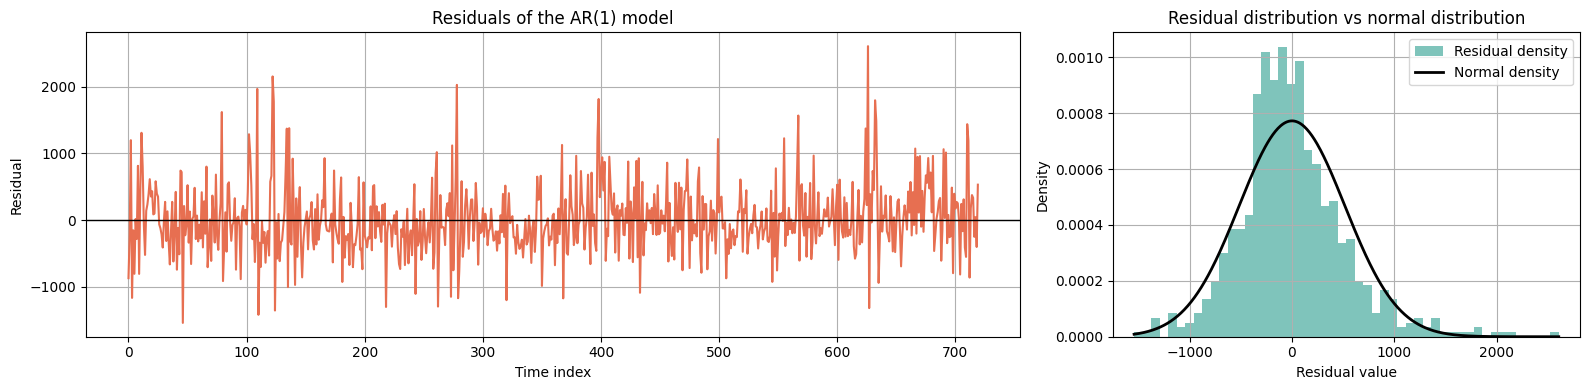

In [254]:
# 1) Fit the selected AR(1) model
p = 1
model = ARIMA(traffic.values, order=(p, 0, 0))
res = model.fit()
print(res.summary())

# 2) Extract residuals
residuals = res.resid

# 3) Combined plot: Residuals over time + histogram with Gaussian overlay
mu = residuals.mean()
sigma = residuals.std(ddof=1)

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Plot Residuals over time (2/3)
ax0 = fig.add_subplot(gs[0])
ax0.plot(residuals, color="#E76F51")
ax0.axhline(0, color="black", linewidth=1)
ax0.set_title("Residuals of the AR(1) model")
ax0.set_xlabel("Time index")
ax0.set_ylabel("Residual")
ax0.grid(True)

# Plot Residual density vs Gaussian density (1/3)
ax1 = fig.add_subplot(gs[1])
ax1.hist(residuals, bins=50, density=True, alpha=0.6, color="#2A9D8F", label="Residual density")
x = np.linspace(residuals.min(), residuals.max(), 500)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=2, label="Normal density")
ax1.set_xlabel("Residual value")
ax1.set_ylabel("Density")
ax1.set_title("Residual distribution vs normal distribution")
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

Based on the model selection results from Question 9, we estimated an AR(1) model on the network traffic time series (number of packets per 10-second interval).

### Model parameters

The estimated autoregressive coefficient is φ ≈ 0.61, highly significant (p-value < 0.001). This indicates a strong short-term dependence: periods of high traffic are likely to be followed by high traffic, and low traffic by low traffic. Such behavior is typical of network traffic, which exhibits burstiness and short-range temporal correlation.

The estimated variance of the innovation term is relatively large, reflecting the high intrinsic variability of packet arrivals.

### Residual time series

The residuals fluctuate around zero and show no obvious remaining linear structure, which suggests that the AR(1) model successfully captures the main short-term dependence in the data. However, the presence of occasional large residuals highlights abrupt traffic bursts that cannot be explained by a simple linear autoregressive model.

The Ljung–Box test does not reject the null hypothesis of no residual autocorrelation at lag 1, indicating that most of the linear temporal dependence has been removed.

### Residual distribution

The histogram of the residuals is approximately centered and bell-shaped, but it clearly deviates from a Gaussian distribution. In particular, the residuals exhibit heavy tails, as confirmed by a high kurtosis value and a strongly significant Jarque–Bera test.

This behavior is consistent with the nature of network traffic, which is known to generate extreme events (sudden traffic surges) more frequently than predicted by a normal distribution.

### Global comment

The AR(1) model provides a reasonable first-order description of the temporal dependence in the traffic data. It captures short-memory effects effectively, but fails to fully account for the non-Gaussian and bursty characteristics of the residuals. This suggests that more advanced models (e.g. higher-order AR models, GARCH-type volatility models, or non-linear approaches) would be required for a more accurate statistical description.


# III - Southern Oscillation Index Data

In this section, we analyze the Southern Oscillation Index (SOI), a monthly climate index related
to the El Niño / La Niña phenomenon. The provided file `soi.tsv` is stored in a wide format, where
all monthly observations are contained in a single row. We reshape this data into a standard
monthly time series and remove missing values.

In [255]:
# Load raw SOI file 
df = pd.read_csv("./soi.tsv", sep="\t", header=None)
print("Raw shape:", df.shape)

# Extract the single row as a 1D array
values = df.iloc[0].astype(str)

# Convert to numeric
soi_values = pd.to_numeric(
    values.str.replace(",", ".", regex=False),
    errors="coerce"
)

# Build a monthly date index
## Assumption: data are monthly and start in January of a known year / The BOM SOI dataset usually starts in 1951-01
start_date = "1951-01-01"
dates = pd.date_range(start=start_date, periods=len(soi_values), freq="MS")

# Build the time series
soi = pd.Series(soi_values.values, index=dates, name="SOI")

# Remove missing values
soi = soi.dropna()

print("SOI series")
print("Start:", soi.index.min())
print("End:", soi.index.max())
print("Number of observations:", len(soi))

soi.head()

Raw shape: (1, 781)
SOI series
Start: 1951-01-01 00:00:00
End: 2015-12-01 00:00:00
Number of observations: 780


1951-01-01    1.537160
1951-02-01    0.922168
1951-03-01   -0.104204
1951-04-01   -0.291903
1951-05-01   -0.658745
Freq: MS, Name: SOI, dtype: float64

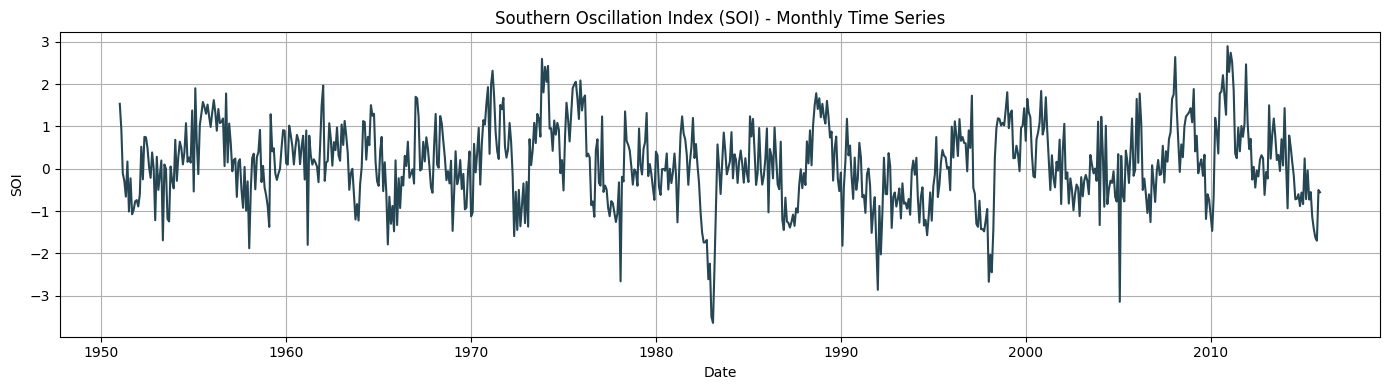

In [256]:
# Plot the cleaned SOI series
plt.figure(figsize=(14, 4))
plt.plot(soi.index, soi.values, color="#264653")
plt.xlabel("Date")
plt.ylabel("SOI")
plt.title("Southern Oscillation Index (SOI) - Monthly Time Series")
plt.grid(True)
plt.tight_layout()
plt.show()

The SOI dataset was successfully converted into a monthly time series. Starting from a wide-format file containing a single row with 781 columns, we reshaped the data into a one-dimensional series indexed by monthly dates.

*Note : We assume that the observations are monthly and start in January 1951, which is consistent with the official Bureau of Meteorology SOI dataset. After removing missing values, the final series contains 780 monthly observations, spanning from January 1951 to December 2015. This start date is chosen to match the official BOM SOI dataset; if metadata differ, the date index should be adjusted accordingly.*

The resulting series is now properly formatted for time-series analysis.


#### Q12 - Autocorrelation and partial autocorrelation of the SOI series

Now, we analyze the temporal dependence structure of the SOI monthly time series by computing
the autocorrelation function (ACF) and the partial autocorrelation function (PACF).
These tools help identify the presence of persistence, seasonality, and potential autoregressive
or moving-average structures.

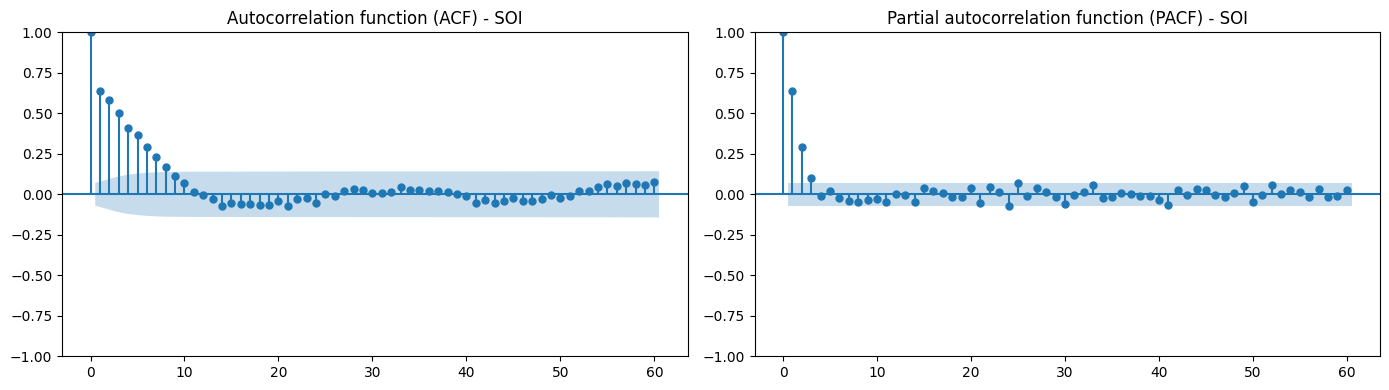

In [257]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Autocorrelation function
plot_acf(soi, lags=60, ax=axes[0])
axes[0].set_title("Autocorrelation function (ACF) - SOI")

# Partial autocorrelation function
plot_pacf(soi, lags=60, ax=axes[1], method="ywm")
axes[1].set_title("Partial autocorrelation function (PACF) - SOI")

plt.tight_layout()
plt.show()

The autocorrelation function (ACF) exhibits a strong positive correlation at short lags, followed by a slow and smooth decay toward zero over roughly 10–12 months. This behavior indicates a persistent process: current SOI values remain influenced by past values over several months. Such gradual decay is typical of climate indices driven by large-scale ocean–atmosphere interactions rather than short-memory noise.

The partial autocorrelation function (PACF) shows a dominant spike at lag 1, with smaller but still significant contributions at lags 2 and 3, after which the partial correlations fall within the confidence bounds. This pattern suggests that most of the temporal dependence can be explained by a low-order autoregressive structure, with limited additional explanatory power beyond the first few lags.

The ACF/PACF combination is consistent with a low-order AR process, such as AR(1) or AR(2), capturing the inertia of the ENSO dynamics. The absence of sharp seasonal peaks confirms that the SOI series is not driven by strict annual seasonality, but rather by interannual oscillations with long memory, which is coherent with the physical interpretation of the Southern Oscillation.


#### Q13 - AR modeling of the SOI series

Based on the ACF and PACF analysis from Question 12, the SOI time series exhibits clear temporal persistence. The autocorrelation function (ACF) decays slowly, which indicates that observations remain correlated over several months. At the same time, the partial autocorrelation function (PACF) shows a dominant and significant spike at lag 1, followed by values that are mostly within the confidence bounds.

This pattern is characteristic of a low-order autoregressive process, and in particular of an AR(1) model. Such a model is consistent with the physical interpretation of the Southern Oscillation Index, which is known to evolve smoothly over time and to exhibit month-to-month persistence rather than strong seasonality.

We therefore select an AR(1) model to describe the dynamics of the SOI series. We now estimate this model, analyze its residuals, and assess whether the Gaussian noise assumption is reasonable.


In [258]:
# Fit AR(1) model
model = ARIMA(soi, order=(1, 0, 0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                    SOI   No. Observations:                  780
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -860.469
Date:                Fri, 23 Jan 2026   AIC                           1726.938
Time:                        12:32:53   BIC                           1740.916
Sample:                    01-01-1951   HQIC                          1732.315
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1280      0.073      1.764      0.078      -0.014       0.270
ar.L1          0.6385      0.025     25.678      0.000       0.590       0.687
sigma2         0.5314      0.023     23.313      0.0

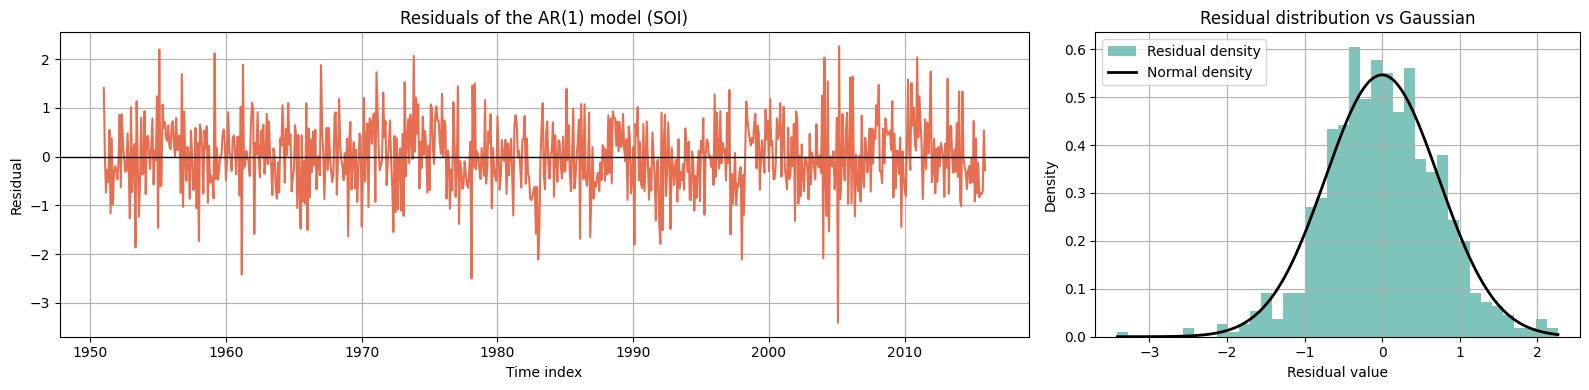

In [259]:
residuals = result.resid

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Residuals plot (2/3)
ax0 = fig.add_subplot(gs[0])
ax0.plot(residuals, color="#E76F51")
ax0.axhline(0, color="black", linewidth=1)
ax0.set_title("Residuals of the AR(1) model (SOI)")
ax0.set_xlabel("Time index")
ax0.set_ylabel("Residual")
ax0.grid(True)

# Histogram (1/3)
ax1 = fig.add_subplot(gs[1])
mu = residuals.mean()
sigma = residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 500)

ax1.hist(residuals, bins=40, density=True, alpha=0.6, color="#2A9D8F", label="Residual density")
ax1.plot(x, stats.norm.pdf(x, mu, sigma), "k", linewidth=2, label="Normal density")
ax1.set_title("Residual distribution vs Gaussian")
ax1.set_xlabel("Residual value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

#### Estimated AR(1) model

The fitted model is:

$$\text{SOI}_t = c + \phi_1 \text{SOI}_{t-1} + \varepsilon_t$$

with the following estimated parameters:

- AR(1) coefficient:
$$\phi_1 \approx 0.64$$

(highly significant, p-value $\approx 0$)

- Intercept:

Small and not strongly significant ($p \approx 0.08$)

- Innovation variance:

$$\sigma^2 \approx 0.53$$

This confirms that the SOI exhibits strong month-to-month persistence, which is consistent with known large-scale climate oscillations such as ENSO.

#### Residual analysis 

- Residual time series : 
The residuals are centered around zero. No obvious remaining trend or seasonal structure is visible. Variance appears roughly stable over time. This indicates that the AR(1) model captures the main temporal dependence of the series.

- Residual distribution vs Gaussian distribution : The empirical residual density is approximately symmetric and bell-shaped. However, compared to a normal distribution with the same mean and variance (The tails are slightly heavier and the kurtosis (> 3) indicates occasional extreme deviations.) This behavior is typical for geophysical time series, where rare but strong events can occur.

#### Statistical diagnostics

- Ljung–Box test: rejects the null hypothesis of no residual autocorrelation ($p \approx 0$). So some dependence remains, but at a weak level.

- Jarque–Bera test: rejects normality. So residuals are not perfectly Gaussian.

These results suggest that while the AR(1) model is a reasonable first-order approximation, more elaborate models (e.g., ARMA or nonlinear models) could further improve the fit.

#### Global comment

The AR(1) model provides a simple and interpretable representation of the SOI dynamics: It successfully captures the dominant persistence of the climate signal. Residuals are well-behaved overall, though not perfectly white nor Gaussian. This level of modeling is appropriate for exploratory analysis and short-term dynamics, but not sufficient for capturing all extremes.
AR(1) is statistically justified, physically interpretable, and consistent with the nature of the SOI data.


#### Q14 - Spectral analysis of the AR model

In this question, we study the frequency-domain representation of the Southern Oscillation Index (SOI) time series.

The objective is to compare:

- the empirical spectral density of the data, estimated using the periodogram;
- the theoretical spectral density associated with the autoregressive model AR(p) estimated in Question 13.

An autoregressive process AR(p) is defined by the equation:

$$
X_t = \sum_{k=1}^{p} \phi_k X_{t-k} + \varepsilon_t,
$$

where $(\varepsilon_t)$ is a white noise process with variance $\sigma^2$.

For such an AR(p) process, the spectral density is given by:

$$
f(\omega) = \sigma^2
\left|
1 - \sum_{k=1}^{p} \phi_k e^{-2 i \pi k \omega}
\right|^{-2},
$$

where $\omega \in [-1/2,\, 1/2]$ denotes the normalized frequency, following the usual signal-processing convention.

The empirical periodogram provides a non-parametric estimate of the spectral density of the observed time series, while the theoretical spectral density reflects the frequency content implied by the fitted AR(p) model.

By superposing the empirical periodogram and the theoretical spectral density, we assess how well the selected AR model captures the dominant frequency components of the SOI series.


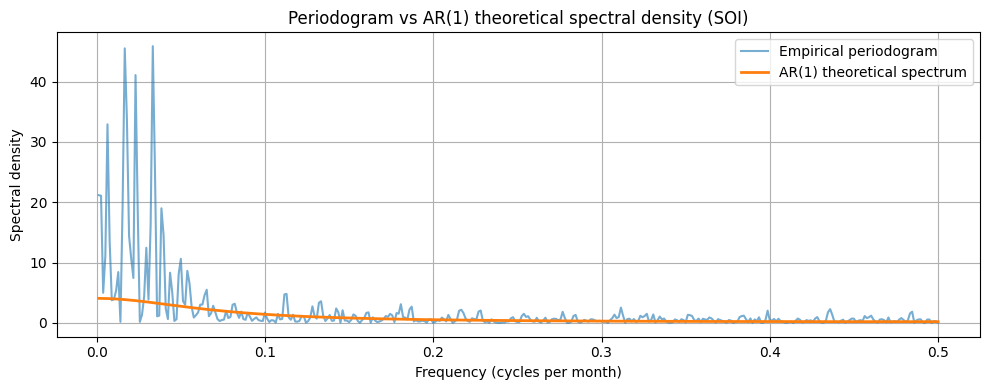

In [260]:
# 1) Empirical periodogram
x = soi.values
fs = 1.0 

freq, Pxx = signal.periodogram(
    x, fs=fs, detrend="constant", window="hann", scaling="density"
)

# Keep positive frequencies
freq_pos = freq[1:]
Pxx_pos = Pxx[1:]

# 2) Theoretical AR(1) spectrum
phi = result.params["ar.L1"]
sigma2 = result.params["sigma2"]

omega = freq_pos
denom = np.abs(1 - phi * np.exp(-2j * np.pi * omega))**2
S_ar = sigma2 / denom

# 3) Plot comparison
plt.figure(figsize=(10,4))

plt.plot(freq_pos, Pxx_pos, label="Empirical periodogram", alpha=0.6)
plt.plot(freq_pos, S_ar, label="AR(1) theoretical spectrum", linewidth=2)

plt.xlabel("Frequency (cycles per month)")
plt.ylabel("Spectral density")
plt.title("Periodogram vs AR(1) theoretical spectral density (SOI)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The theoretical spectral density of the AR(1) model closely matches the low-frequency behavior of the empirical periodogram, capturing the dominant persistence of the SOI series. As expected, the AR(1) spectrum provides a smooth approximation of the noisy periodogram and does not reproduce its fine-scale fluctuations. This confirms that the AR(1) model adequately represents the main frequency-domain structure of the SOI data.